# Analyze by loading all arrays for each sequence

In [1]:
import numpy as np
import numpy.linalg as la
import pykep as pk
from pykep.planet import jpl_lp
from pykep import epoch
import pygmo as pg
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import spiceypy as spice

%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [20]:
import sys
sys.path.append("../")
import pyxplorer as pxp

In [21]:
# get number of files
res_dir = "optim_res_dep_c3_83"
filenames = os.listdir(res_dir)

In [22]:
seq_key = ["earth", "jupiter", "saturn"]
seq_name = ""
for el in seq_key:
    seq_name += el + "-"
seq_name = seq_name[:-1]

In [23]:
# get solar system
ssdict = pxp.solar_system_spice()

tof = [
    [2/pk.DAY2YEAR, 6/pk.DAY2YEAR] for el in range(len(seq_key)-1)
]

pop_list = []
prob_list = []

i_window = 0
t0_iter = [
    pk.epoch_from_string('2044-01-01 00:00:00.000').mjd2000 + i_window*30,
    pk.epoch_from_string('2044-01-01 00:00:00.000').mjd2000 + (i_window+1)*30

]
# run problem
seq = [ssdict[el] for el in seq_key]

prob_test = pxp.get_depart_problem(seq, t0_iter, tof)

In [24]:
n_data_already = 0
for filename in filenames:
    if "seq_" + seq_name + "_" in filename:
        if n_data_already == 0:
            xload = np.load(
                os.path.join(res_dir, filename)
            )
        else:
            xload = np.concatenate(
                (xload, 
                    np.load(os.path.join(res_dir, filename))
                )
            )
        n_data_already += 1
n_data_already

15

In [25]:
ndat, _ = xload.shape
fload = []

for idx in range(ndat):
    fload.append(
        prob_test.fitness(xload[idx,:])
    )

In [26]:
dvs, _, _, _, _ = prob_test._compute_dvs(xload[0])
dvs

[6814.780605663439, 1.364982736941751e-06, 3181.736434855263]

In [27]:
prob_test.fitness(xload[0])

[9996.517041883684]

In [28]:
porkchop_return = pxp.porkchop_process(
    prob_test, xload, fload, len(seq_key)-1, direction="depart"
)

  0%|          | 0/45000 [00:00<?, ?it/s]

In [29]:
min_dsm_idx = porkchop_return["idx"][np.argmin(porkchop_return['dsm_total'])]
prob_test.pretty(xload[min_dsm_idx])

First Leg: 3, SUN, ECLIPJ2000 to 5, SUN, ECLIPJ2000
Departure: 2032-Apr-02 19:34:45.879703 (11780.815808792857 mjd2000) 
Duration: 1101.6090807240773days
VINF: 9.110433577290818 km/sec
DSM after 332.35208997044657 days
DSM magnitude: 137.0758953541795m/s

leg no. 2: 5, SUN, ECLIPJ2000 to 6, SUN, ECLIPJ2000
Duration: 2191.4999999252586days
Fly-by epoch: 2035-Apr-09 10:11:50.454263 (12882.424889516935 mjd2000) 
Fly-by radius: 18.150441532753874 planetary radii
DSM after 852.515873966327 days
DSM magnitude: 5.188945261765102e-06m/s

Arrival at 6, SUN, ECLIPJ2000
Arrival epoch: 2041-Apr-08 22:11:50.447805 (15073.924889442193 mjd2000) 
Arrival Vinf: 5407.407469215297m/s
Total mission time: 9.016041288567655 years (3293.1090806493357 days)


<IPython.core.display.Javascript object>


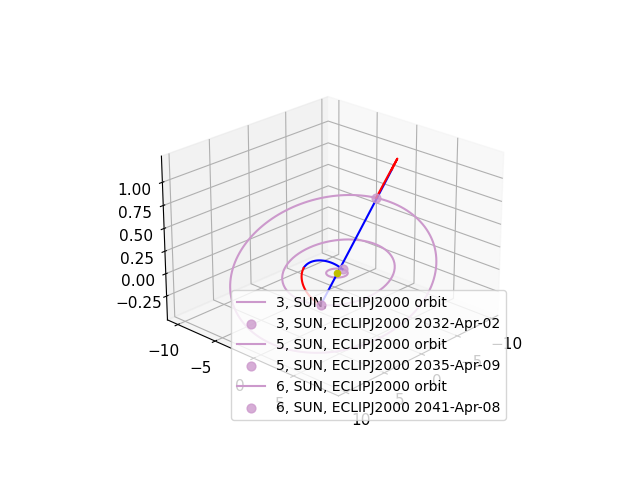

<Axes3DSubplot:>

In [30]:
prob_test.plot(xload[min_dsm_idx])

In [31]:
# plt.rcParams["font.size"] = 11

# fig, ax = plt.subplots(1,1,figsize=(11,4))

# im0 = ax.scatter(porkchop_return['t0_matplotlib'], porkchop_return['tof_total']*pk.DAY2YEAR, 
#                      c=porkchop_return['dsm_total']/1e3, cmap='winter', s=15, marker='x')

# fig.colorbar(im0, label='Total DSM DV, km/s')
# ax.set_title(seq_name)
# ax.set(xlabel="Departure, year", ylabel="TOF, year")
# ax.grid(True, alpha=0.3)

# plt.show()

<IPython.core.display.Javascript object>


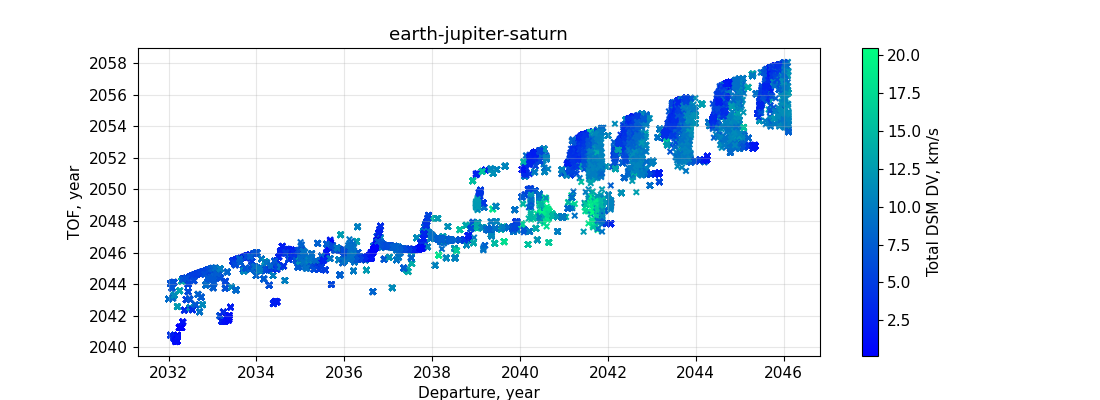

In [32]:
plt.rcParams["font.size"] = 11

fig, ax = plt.subplots(1,1,figsize=(11,4))

im0 = ax.scatter(porkchop_return['t0_matplotlib'], porkchop_return['tf_matplotlib'],#*pk.DAY2YEAR, 
                     c=porkchop_return['dsm_total']/1e3, cmap='winter', s=15, marker='x')

fig.colorbar(im0, label='Total DSM DV, km/s')
ax.set_title(seq_name)
ax.set(xlabel="Departure, year", ylabel="TOF, year")
ax.grid(True, alpha=0.3)

plt.show()

In [33]:
plt.savefig("./plots/seq_"+seq_name+"_dsm_dv.png")

<IPython.core.display.Javascript object>


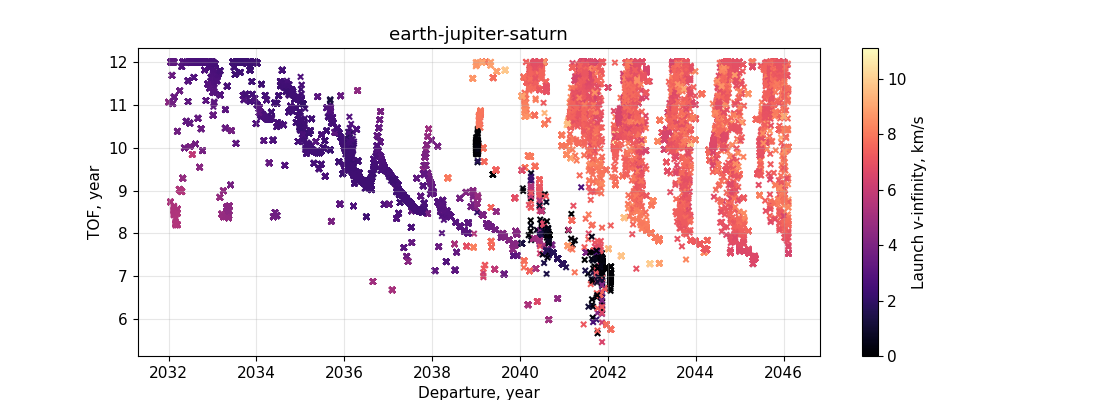

In [34]:
plt.rcParams["font.size"] = 11

fig, ax = plt.subplots(1,1,figsize=(11,4))

im0 = ax.scatter(porkchop_return['t0_matplotlib'], porkchop_return['tof_total']*pk.DAY2YEAR, 
                     c=porkchop_return['launch_deltaV']/1e3, cmap='magma', s=15, marker='x')

fig.colorbar(im0, label='Launch v-infinity, km/s')
ax.set_title(seq_name)
ax.set(xlabel="Departure, year", ylabel="TOF, year")
ax.grid(True, alpha=0.3)

plt.show()

In [35]:
plt.savefig("./plots/seq_"+seq_name+"_vinf_arr.png")

### Index of solution

In [ ]:
plt.rcParams["font.size"] = 11

fig, ax = plt.subplots(1,1,figsize=(11,4))

im0 = ax.scatter(porkchop_return['t0_matplotlib'], porkchop_return['tof_total']*pk.DAY2YEAR, 
                     c=porkchop_return['idx'], cmap='plasma', s=15, marker='x')

fig.colorbar(im0, label='Index')
ax.set_title(seq_name)
ax.set(xlabel="Departure, year", ylabel="TOF, year")

plt.show()